Description: improved version of original financial-ratios.ipynb. I went back and manually scraped price data to improve the training set size. 

# 1 Import packages and define useful functions

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import plotly.express as px
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
def convert_placeholder_text_to_num(text):
    '''
    Parsing helper script. In a lot of investing.com data e.g.6.1 M is used to indicate 6.1 million. This script converts the string 
    into float for machine learning to be carried out. 
    '''
    result = text
    try:
        if text[-1] == 'M':
            result = float(text[:-2]) * 10**6
        elif text[-1] == 'B':
            result = float(text[:-2]) * 10**9
        elif text[-1] == 'K':
            result = float(text[:-2]) * 10**3
        elif text[-1] == '-':
            result = np.nan
        elif text[-1] == 'nan':
            result = np.nan
        elif text[-1] == 'NA':
            result = np.nan
        elif text[-1] == 'x':
            result = float(text[:-1])
        elif text[-1] == '%':
            result = text.replace(",","")
            result = float(result[:-1])*0.01
    except Exception as e:
        pass
        #print(e)
       
    return result

In [12]:
def get_historical_yfinance(ticker):
    '''
    From ticker string in dataframes above, download historical data (5Y), skip if it's not present
    '''
    
    try:
        ticker = f'{ticker:04}'+'.HK' # convert ticker to yfinace form
        asset = yf.Ticker(ticker)
        hist = asset.history(period="3Y")
    except error as e:
        print(e)
        print(str(ticker))
        print('\n')
        
    return hist

# old code to download historical price data (doesn't work)
#historical_price_data = {}

#for elem in test_merge.Ticker:
#    historical_price_data[elem] = get_historical_yfinance(elem)

# 2 Import data

In [4]:
# just read in the two excel frames and go from there

In [3]:
test_merge = pd.read_excel('test_manual.xlsx')

In [4]:
test_merge = test_merge.loc[:, test_merge.columns != 'Unnamed: 0']

In [5]:
test_assets = pd.read_excel('asset_prices.xlsx',index_col='Date')
# pd.read_pickle('data/price_data_complete.pickle')

In [6]:
test_assets.head()

,2322.HK,1023.HK,1468.HK,1243.HK,1373.HK,1140.HK,1499.HK,1082.HK,9913.HK,2232.HK,...,0029.HK,0026.HK,0025.HK,0018.HK,0199.HK,0179.HK,0186.HK,0247.HK,1272.HK,1989.HK
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,0.60,1.224793,0.239,0.852034,1.133839,2.984653,0.60,0.520,NaN,7.022158,...,7.407843,57.493649,9.228558,0.534670,1.911842,23.406488,1.36,25.15,2.58,0.72
2018-05-01,0.70,1.210384,0.237,0.790193,1.233674,3.051189,0.91,0.520,NaN,6.039824,...,7.903154,57.838318,9.288484,0.676967,1.898038,20.502031,1.26,25.05,2.69,0.76
2018-06-01,0.67,1.210384,0.227,0.755837,1.219412,2.956137,0.85,0.500,NaN,4.197947,...,7.431910,57.838318,8.943911,0.662409,1.787607,19.519642,1.02,24.95,2.69,0.72
2018-07-01,0.60,1.628255,0.246,0.755837,1.390557,2.861084,0.72,0.455,NaN,3.925160,...,7.314098,57.956352,9.093725,0.676967,1.684078,19.861340,1.09,25.20,2.72,0.70
2018-08-01,0.58,1.621050,0.355,0.748966,1.411951,2.823063,0.67,0.405,NaN,3.823715,...,6.675957,56.894016,8.943911,0.655130,1.637190,19.937471,0.98,25.20,2.98,0.60


In [7]:
test_merge.head()

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
0,199,ITC Properties Group Limited,Real Estate,Real Estate Management & Development,Real Estate,122.1 M,2023,48.338 M,75.623 M,101 M,...,51.5%,89.9%,89.9%,77.3%,77.3%,83.6%,83.6%,83.9%,83.9%,84.7%
1,2322,Hong Kong ChaoShang Group Limited,Industrials,Trading Companies & Distributors,Capital Goods,383.2 M,2023,365.2 M,438.8 M,409.7 M,...,1.5%,0.7%,0.7%,2.1%,2.1%,2.8%,2.8%,3.7%,3.7%,4.4%
2,179,Johnson Electric Holdings Limited,Consumer Discretionary,Auto Components,Automobiles & Components,1.056 B,2023,1.265 B,1.435 B,1.384 B,...,25.6%,28.0%,28.0%,21.3%,21.3%,24.7%,24.7%,26.0%,26.0%,22.4%
3,247,Tsim Sha Tsui Properties Limited,Real Estate,Real Estate Management & Development,Real Estate,5.729 B,2023,12.229 B,10.462 B,9.692 B,...,7.8%,7.7%,7.7%,11.0%,11.0%,11.7%,11.7%,11.7%,11.7%,10.6%
4,989,Hua Yin International Holdings Limited,Real Estate,Real Estate Management & Development,Real Estate,385.4 M,2023,511.3 M,592.7 M,537.9 M,...,-418.4%,-400.0%,-400.0%,-374.6%,-374.6%,-133.7%,-133.7%,-147.2%,-147.2%,182.2%


In [13]:
ML_data = test_merge.map(convert_placeholder_text_to_num)

In [14]:
ML_data.head()

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
0,199,ITC Properties Group Limited,Real Estate,Real Estate Management & Development,Real Estate,1.221000e+08,2023,4.833800e+07,7.562300e+07,1.010000e+08,...,0.515,0.899,0.899,0.773,0.773,0.836,0.836,0.839,0.839,0.847
1,2322,Hong Kong ChaoShang Group Limited,Industrials,Trading Companies & Distributors,Capital Goods,3.832000e+08,2023,3.652000e+08,4.388000e+08,4.097000e+08,...,0.015,0.007,0.007,0.021,0.021,0.028,0.028,0.037,0.037,0.044
2,179,Johnson Electric Holdings Limited,Consumer Discretionary,Auto Components,Automobiles & Components,1.056000e+09,2023,1.265000e+09,1.435000e+09,1.384000e+09,...,0.256,0.280,0.280,0.213,0.213,0.247,0.247,0.260,0.260,0.224
3,247,Tsim Sha Tsui Properties Limited,Real Estate,Real Estate Management & Development,Real Estate,5.729000e+09,2023,1.222900e+10,1.046200e+10,9.692000e+09,...,0.078,0.077,0.077,0.110,0.110,0.117,0.117,0.117,0.117,0.106
4,989,Hua Yin International Holdings Limited,Real Estate,Real Estate Management & Development,Real Estate,3.854000e+08,2023,5.113000e+08,5.927000e+08,5.379000e+08,...,-4.184,-4.000,-4.000,-3.746,-3.746,-1.337,-1.337,-1.472,-1.472,1.822


In [15]:
ratio_ticker_list = list(ML_data.Ticker)
ratio_ticker_list_new = []

for elem in ratio_ticker_list:
    ticker = f'{elem:04}'+'.HK'
    ratio_ticker_list_new.append(ticker)

asset_ticker_list = list(test_assets.columns)

combined_tickers = [value for value in asset_ticker_list if value in ratio_ticker_list_new]

combined_tickers
combined_ticker_int = []

for elem in combined_tickers:
    combined_ticker_int.append(int(elem[:-3]))

ML_final = ML_data[ML_data['Ticker'].isin(combined_ticker_int)]

In [16]:
# Inspect output
# ML_final.to_excel('check.xlsx')
# Check for duplicates
ML_final = ML_final.drop_duplicates(subset='Ticker')

# somewhat counterintuitively, bfill actually means ffill in my dataframes because everything is in reverse order. I manually checked this. 
# also need to ffill since sometimes theres no data at all. otherwise pct_change throws an error
ML_final = ML_final.bfill(axis=1)
ML_final = ML_final.ffill(axis=1)

In [14]:
ML_final.head()

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
0,199,ITC Properties Group Limited,Real Estate,Real Estate Management & Development,Real Estate,1.221000e+08,2023,4.833800e+07,7.562300e+07,1.010000e+08,...,0.515,0.899,0.899,0.773,0.773,0.836,0.836,0.839,0.839,0.847
1,2322,Hong Kong ChaoShang Group Limited,Industrials,Trading Companies & Distributors,Capital Goods,3.832000e+08,2023,3.652000e+08,4.388000e+08,4.097000e+08,...,0.015,0.007,0.007,0.021,0.021,0.028,0.028,0.037,0.037,0.044
2,179,Johnson Electric Holdings Limited,Consumer Discretionary,Auto Components,Automobiles & Components,1.056000e+09,2023,1.265000e+09,1.435000e+09,1.384000e+09,...,0.256,0.280,0.280,0.213,0.213,0.247,0.247,0.260,0.260,0.224
3,247,Tsim Sha Tsui Properties Limited,Real Estate,Real Estate Management & Development,Real Estate,5.729000e+09,2023,1.222900e+10,1.046200e+10,9.692000e+09,...,0.078,0.077,0.077,0.110,0.110,0.117,0.117,0.117,0.117,0.106
4,989,Hua Yin International Holdings Limited,Real Estate,Real Estate Management & Development,Real Estate,3.854000e+08,2023,5.113000e+08,5.927000e+08,5.379000e+08,...,-4.184,-4.000,-4.000,-3.746,-3.746,-1.337,-1.337,-1.472,-1.472,1.822


In [17]:
list(set(ML_final['Sector'].tolist()))

['Real Estate',
 'Healthcare',
 'Energy',
 'Communication Services',
 'Consumer Staples',
 'Information Technology',
 'Financials',
 'Industrials',
 'Consumer Discretionary']

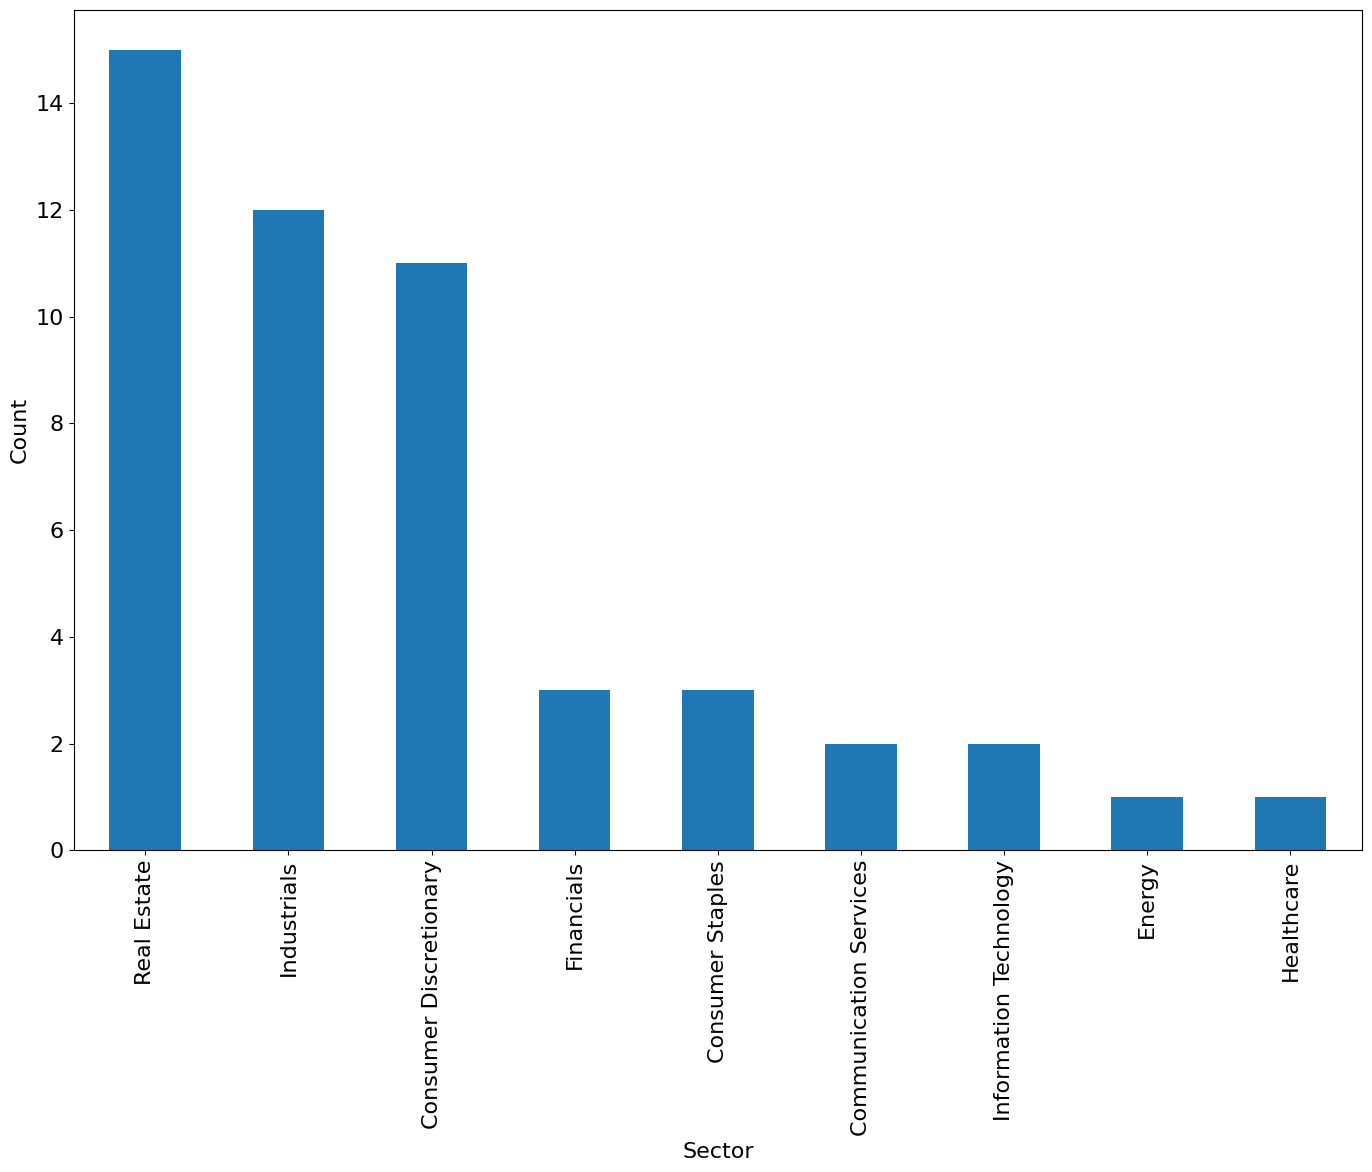

In [31]:
# ML_final['Sector'].hist(xrot=90,bins=11). Maybe useful for marketcap visualisation
plt.rcParams["figure.figsize"] = (14, 12)
plt.rcParams.update({'font.size': 16})
fig = ML_final['Sector'].value_counts().plot.bar()#.get_figure()#plot.bar()
fig.set_ylabel("Count")
fig = fig.get_figure()
fig.tight_layout()
fig.savefig("sector_counts.png") 

# could do a stacked or subplot comparing original dataset without dropna vs this one? See pandas barchart. 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

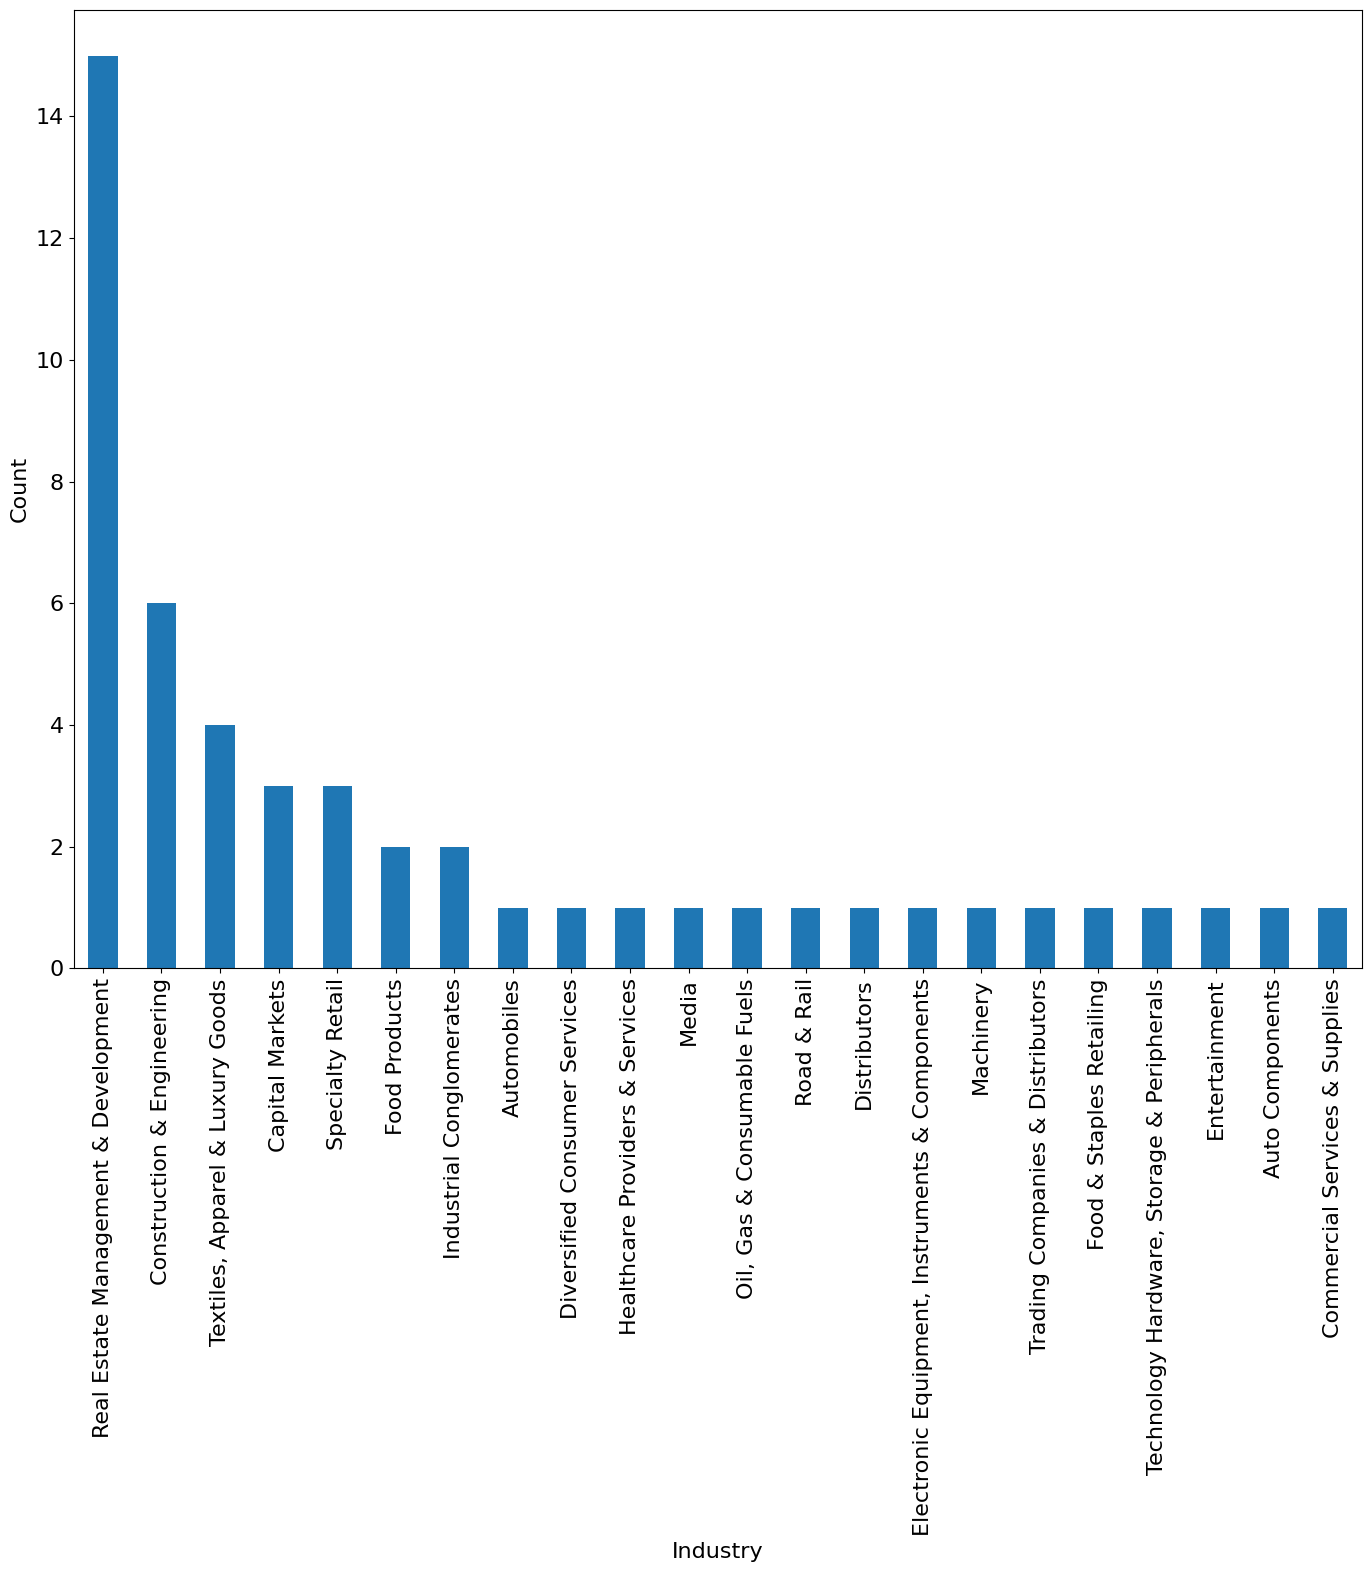

In [34]:

# ML_final['Sector'].hist(xrot=90,bins=11). Maybe useful for marketcap visualisation
plt.rcParams["figure.figsize"] = (14, 16)
plt.rcParams.update({'font.size': 16})
fig = ML_final['Industry'].value_counts().plot.bar()#.get_figure()#plot.bar()
fig.set_ylabel("Count")
fig = fig.get_figure()
fig.tight_layout()
fig.savefig("industry_counts.png") 

# could do a stacked or subplot comparing original dataset without dropna vs this one? See pandas barchart. 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

(array([20.,  7.,  6.,  3.,  4.,  2.,  1.,  0.,  0.,  7.]),
 array([1.035e+08, 1.635e+08, 2.235e+08, 2.835e+08, 3.435e+08, 4.035e+08,
        4.635e+08, 5.235e+08, 5.835e+08, 6.435e+08, 7.035e+08]),
 <BarContainer object of 10 artists>)

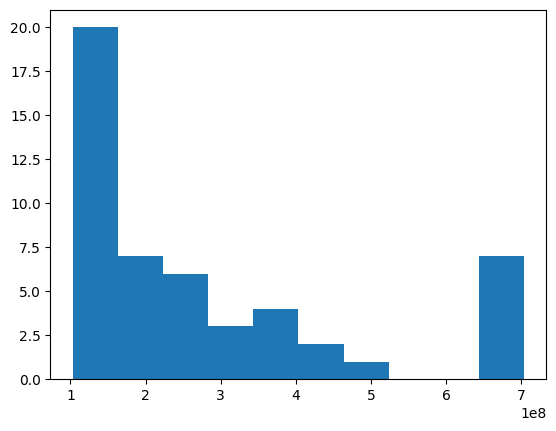

In [17]:
#ML_final['Market Cap'].hist(xrot=90,bins=np.linspace(103500000,703500000,11))
plt.hist(np.clip(ML_final['Market Cap'],a_min=103500000,a_max=703500000),bins=np.linspace(103500000,703500000,11))
# need axis labels
# tried doing this with np.clip:
## https://stackoverflow.com/questions/26218704/matplotlib-histogram-with-collection-bin-for-high-values
# I tried doing this with logarithmic scale.

In [18]:
ML_final['Market Cap'].min()

103500000.0

In [19]:
ML_final['Market Cap'].max()

13581000000.0

In [20]:
# Dealing with imbalanced datasets
# https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
# 

# 3 Machine learning (previously section 4)

In [21]:
test_assets.columns

Index(['2322.HK', '1023.HK', '1468.HK', '1243.HK', '1373.HK', '1140.HK',
       '1499.HK', '1082.HK', '9913.HK', '2232.HK', '2221.HK', '2033.HK',
       '1942.HK', '1726.HK', '1283.HK', '1188.HK', '1125.HK', '0992.HK',
       '0989.HK', '0985.HK', '0938.HK', '0931.HK', '0711.HK', '0677.HK',
       '0411.HK', '0391.HK', '0374.HK', '0367.HK', '0306.HK', '0259.HK',
       '0213.HK', '0163.HK', '0160.HK', '0149.HK', '0147.HK', '0129.HK',
       '0113.HK', '0105.HK', '0057.HK', '0053.HK', '0029.HK', '0026.HK',
       '0025.HK', '0018.HK', '0199.HK', '0179.HK', '0186.HK', '0247.HK',
       '1272.HK', '1989.HK'],
      dtype='object')

In [22]:
asset_prices = test_assets#.dropna(axis=1)

# resample monthly to quarterly intervals
asset_prices.index = pd.to_datetime(asset_prices.index)
asset_prices = asset_prices.resample('Q').last()

# drop the last quarter (probably not necessary for t+1, but need to adjust 
# depending on how many periods you want to go forward

# somewhat counterintuitively, bfill actually means ffill in my dataframes because everything is in reverse order. I manually checked this. 
# also need to ffill since sometimes theres no data at all. otherwise pct_change throws an error

asset_prices = asset_prices.bfill(axis=1)
asset_prices = asset_prices.ffill(axis=1)

In [23]:
asset_prices.tail()

,2322.HK,1023.HK,1468.HK,1243.HK,1373.HK,1140.HK,1499.HK,1082.HK,9913.HK,2232.HK,...,0029.HK,0026.HK,0025.HK,0018.HK,0199.HK,0179.HK,0186.HK,0247.HK,1272.HK,1989.HK
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,0.84,0.448684,0.57,0.056084,2.389584,0.600,0.225,1.57,3.02,2.769933,...,10.762691,88.237961,8.459397,0.622245,0.981869,10.146840,0.405,22.40,0.90,0.85
2022-06-30,0.89,0.410088,0.57,0.056885,2.591779,0.440,0.172,1.76,2.56,2.405935,...,9.878703,83.778625,8.396065,0.659394,1.134393,9.547765,0.440,22.30,0.87,0.90
2022-09-30,0.85,0.477632,0.53,0.057000,2.610161,0.425,0.151,1.60,2.41,2.331105,...,7.990861,71.958748,6.622758,0.572121,0.960000,7.509090,0.370,22.20,0.95,0.90
2022-12-31,0.76,0.580000,0.92,0.060000,2.810814,0.405,0.200,1.78,2.12,2.274933,...,8.939775,69.550484,6.627479,0.533333,1.000000,9.534753,0.270,21.78,0.96,0.90
2023-03-31,0.73,0.870000,1.67,0.057000,2.880000,0.370,0.345,1.70,2.14,2.527704,...,9.995000,74.557236,6.685219,0.620000,1.050000,8.632686,0.330,22.00,0.92,0.92


In [24]:
ML_final.tail()

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
46,1942,MOG Holdings Limited,Consumer Discretionary,Specialty Retail,Retailing,1.543000e+09,2023,1.474000e+09,9.055500e+07,53108000.0,...,0.139,0.153,0.153,0.170,0.170,0.168,0.168,0.338,0.338,0.375
47,1283,Accel Group Holdings Limited,Industrials,Construction & Engineering,Capital Goods,1.294000e+08,2023,1.212000e+08,1.512000e+08,136300000.0,...,0.049,0.033,0.033,0.055,0.055,0.017,0.017,0.011,0.011,0.076
48,1188,Hybrid Kinetic Group Limited,Consumer Discretionary,Automobiles,Automobiles & Components,1.037000e+08,2022,9.135300e+07,7.659700e+07,87668000.0,...,0.285,0.256,0.256,0.215,0.215,0.217,0.217,0.349,0.349,0.044
49,2232,Crystal International Group Limited,Consumer Discretionary,"Textiles, Apparel & Luxury Goods",Consumer Durables & Apparel,1.047000e+09,2022,7.137000e+08,6.329000e+08,771900000.0,...,0.118,0.154,0.154,0.175,0.175,0.174,0.174,0.285,0.285,0.282
50,1272,"Datang Environment Industry Group Co., Ltd.",Industrials,Commercial Services & Supplies,Commercial & Professional Services,3.591000e+08,2022,1.023000e+09,1.036000e+09,883800000.0,...,0.675,0.866,0.631,0.727,0.554,0.841,0.813,0.921,0.856,1.004


In [25]:
def extract_financial_ratio(fratio, ML_dataframe):
    '''
    Given a financial ratio (list below), return a dataframe [X1,X2,...,y1,y2,...] where Xi are the financial ratios and yi are the % returns for the asset.
    Vertical axis is time (in decreasing order)
    
    Financial ratios: 
    - EV
    - FCF
    - EBITDA
    - Revenue
    - ROE
    - Gross-Profit-Margin
    - Quick-Ratio
    - Debt / Equity

    Note that FQ corresponds to 2022-12-31 and FQ-1 corresponds to the preceding quarter etc. 
    '''
  
    
    df = ML_dataframe.loc[:,ML_dataframe.columns.str.contains('Ticker') | ML_dataframe.columns.str.contains(fratio)]
    df = df.set_index('Ticker')
    df = df.transpose()
    df = df.pct_change(-1)
    
    return df

In [26]:
def get_returns(asset_prices_df):
    '''
    From asset prices dataframe defined above, do the following:
    - reverse its order
    - calculate percent returns
    - restrict period to between pd.Timestamp('2023-03-31'):pd.Timestamp('2020-03-31') # this is the period for which 
    company valuation metrics have been obtained
    '''
    
    df = asset_prices_df[::-1].pct_change(-1)[pd.Timestamp('2023-03-31'):pd.Timestamp('2020-03-31')]
    
    return df

In [27]:
test = extract_financial_ratio('EV',ML_final)
test2 = get_returns(asset_prices)

In [28]:
test.head()

Ticker,199,2322,179,247,989,105,25,1023,1468,1243,...,1989,1499,1082,374,9913,1942,1283,1188,2232,1272
EV,-0.360803,-0.167730,-0.118467,0.168897,-0.137338,-0.215536,-0.235294,1.141936,2.163367,-0.341322,...,0.241358,0.761468,0.087814,-0.076962,-0.163570,15.277400,-0.198413,0.192645,0.127666,-0.012548
EV FQ-1,-0.251257,0.071028,0.036850,0.079447,0.101878,-0.073121,0.383255,0.183935,-0.005370,-0.261745,...,0.158006,0.223001,-0.107200,-0.080056,-0.176278,0.705110,0.109318,-0.126283,-0.180075,0.172211
EV FQ-2,-0.026975,-0.117976,-0.328155,0.004456,-0.264461,-0.013252,-0.123967,-0.203670,-0.149958,-0.305214,...,-0.309408,-0.165105,0.139471,-0.045495,-0.139666,0.019817,-0.034018,0.083793,-0.163252,-0.166226
EV FQ-3,0.258930,0.023128,0.118350,0.016219,0.359294,-0.046173,0.079153,0.415586,-0.025214,0.062613,...,0.110393,-0.024000,-0.049393,0.112531,0.030031,0.353713,0.039028,1.192557,0.250847,0.046397
EV FQ-4,-0.475836,-0.115871,-0.188189,0.011074,-0.026244,-0.063466,-0.233661,-0.090339,-0.016691,0.110000,...,-0.098544,-0.152953,-0.001730,-0.101148,0.066925,0.059402,0.021053,0.129989,-0.090405,-0.070642


In [217]:
test2.head()

,2322.HK,1023.HK,1468.HK,1243.HK,1373.HK,1140.HK,1499.HK,1082.HK,9913.HK,2232.HK,...,0029.HK,0026.HK,0025.HK,0018.HK,0199.HK,0179.HK,0186.HK,0247.HK,1272.HK,1989.HK
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-31,-0.039474,0.500000,0.815217,-0.050000,0.024614,-0.086420,0.725000,-0.044944,0.009434,0.111111,...,0.118037,0.071987,0.008712,0.162501,0.050000,-0.094608,0.222222,0.010101,-0.041667,0.022222
2022-12-31,-0.105882,0.214325,0.735849,0.052632,0.076874,-0.047059,0.324503,0.112500,-0.120332,-0.024097,...,0.118750,-0.033467,0.000713,-0.067797,0.041667,0.269761,-0.270270,-0.018919,0.010526,0.000000
2022-09-30,-0.044944,0.164706,-0.070175,0.002014,0.007092,-0.034091,-0.122093,-0.090909,-0.058594,-0.031102,...,-0.191102,-0.141085,-0.211207,-0.132353,-0.153732,-0.213524,-0.159091,-0.004484,0.091954,0.000000
2022-06-30,0.059524,-0.086021,0.000000,0.014286,0.084615,-0.266667,-0.235556,0.121019,-0.152318,-0.131410,...,-0.082134,-0.050538,-0.007487,0.059702,0.155340,-0.059041,0.086420,-0.004464,-0.033333,0.058824
2022-03-31,-0.106383,-0.049020,-0.149254,-0.135803,-0.060744,-0.250000,-0.150943,-0.048485,-0.129683,0.190840,...,0.057910,-0.013969,0.016198,0.044777,-0.036178,-0.343826,-0.173469,-0.054852,-0.181818,0.491228


In [41]:
def ticker_to_fratio_frame(ticker, fratio_df, returns_df,shift=-1):
    '''
    ticker - int obtained from cols: extract_financial_ratio('EV',ML_final).columns
    fratio_df - this is ML_final as above
    returns_df - this is usually get_returns(asset_prices)
    
    shift - -1 (default, returns are coincident with company valuation metrices), 
        0 -  (returns lead financial ratios by one time period leading)
        1 - (" 2 time periods etc.)
    '''
    
    col_names = ['EV','FCF','EBITDA','Revenue','ROE','Gross-Profit-Margin','Quick-Ratio','Debt / Equity', 'Returns']

    ticker_returns_df = f'{ticker:004}'+'.HK'

    # get financial ratios
    #for fratio in financial_ratios:
        # create temp dfs
    EV_tmp = extract_financial_ratio('EV',fratio_df)
    FCF_tmp = extract_financial_ratio('FCF',fratio_df)
    EBITDA_tmp = extract_financial_ratio('EBITDA',fratio_df)
    REV_tmp = extract_financial_ratio('Revenue',fratio_df)
    ROE_tmp = extract_financial_ratio('ROE',fratio_df)
    GPM_tmp = extract_financial_ratio('Gross-Profit-Margin',fratio_df)
    QR_tmp = extract_financial_ratio('Quick-Ratio',fratio_df)
    DE_tmp = extract_financial_ratio('Debt / Equity',fratio_df)

    df = pd.concat([EV_tmp[ticker].reset_index(drop=True),FCF_tmp[ticker].reset_index(drop=True),\
          EBITDA_tmp[ticker].reset_index(drop=True), REV_tmp[ticker].reset_index(drop=True),\
              ROE_tmp[ticker].reset_index(drop=True), GPM_tmp[ticker].reset_index(drop=True),\
              QR_tmp[ticker].reset_index(drop=True), DE_tmp[ticker].reset_index(drop=True),\
                   returns_df[ticker_returns_df].shift(shift).reset_index(drop=True)],axis=1)

    df.columns = col_names

        #df = extract_financial_ratio(fratio,ML_final)
    return df


In [371]:
ticker_to_fratio_frame(199,ML_final, get_returns(asset_prices),0)

# next steps, iterate over tickers
# drop Nan at the end

tickers = extract_financial_ratio('EV',ML_final).columns

In [376]:
ML_final;

In [37]:
def get_ML_sector_filtered(ML_final,sector=None):
    if sector is not None:
        df = ML_final[ML_final['Sector'] == sector]
    else:
        df = ML_final
    return df

real_estate = get_ML_sector_filtered(ML_final,'Real Estate')

In [49]:
real_estate

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
0,199,ITC Properties Group Limited,Real Estate,Real Estate Management & Development,Real Estate,1.221000e+08,2023,4.833800e+07,7.562300e+07,1.010000e+08,...,0.515,0.899,0.899,0.773,0.773,0.836,0.836,0.839,0.839,0.847
3,247,Tsim Sha Tsui Properties Limited,Real Estate,Real Estate Management & Development,Real Estate,5.729000e+09,2023,1.222900e+10,1.046200e+10,9.692000e+09,...,0.078,0.077,0.077,0.110,0.110,0.117,0.117,0.117,0.117,0.106
4,989,Hua Yin International Holdings Limited,Real Estate,Real Estate Management & Development,Real Estate,3.854000e+08,2023,5.113000e+08,5.927000e+08,5.379000e+08,...,-4.184,-4.000,-4.000,-3.746,-3.746,-1.337,-1.337,-1.472,-1.472,1.822
5,105,Associated International Hotels Limited,Real Estate,Real Estate Management & Development,Real Estate,4.297000e+08,2023,3.898000e+08,4.969000e+08,5.361000e+08,...,0.021,0.020,0.020,0.019,0.019,0.017,0.017,0.016,0.016,0.015
9,1243,Wang On Properties Limited,Real Estate,Real Estate Management & Development,Real Estate,1.104000e+08,2023,1.594000e+08,2.420000e+08,3.278000e+08,...,0.886,1.015,1.015,0.980,0.980,0.941,0.941,0.767,0.767,0.807
13,367,Chuang's Consortium International Limited,Real Estate,Real Estate Management & Development,Real Estate,1.385000e+08,2023,2.983000e+08,3.923000e+08,4.210000e+08,...,0.513,0.593,0.593,0.637,0.637,0.611,0.611,0.645,0.645,0.640
14,938,Man Sang International Limited,Real Estate,Real Estate Management & Development,Real Estate,1.377000e+08,2023,4.801000e+08,4.872000e+08,4.883000e+08,...,14.718,69.297,69.297,15.689,15.689,6.153,6.153,9.844,9.844,4.087
15,160,"Hon Kwok Land Investment Company, Limited",Real Estate,Real Estate Management & Development,Real Estate,1.946000e+08,2023,6.074000e+08,6.417000e+08,6.552000e+08,...,0.454,0.451,0.451,0.478,0.478,0.503,0.503,0.520,0.520,0.434
20,26,"China Motor Bus Company, Limited",Real Estate,Real Estate Management & Development,Real Estate,4.415000e+08,2023,3.616000e+08,4.219000e+08,4.291000e+08,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21,129,Asia Standard International Group Limited,Real Estate,Real Estate Management & Development,Real Estate,1.076000e+08,2023,1.091000e+09,8.305000e+08,8.257000e+08,...,1.085,1.071,1.071,0.801,0.801,0.868,0.868,1.008,1.008,0.808


In [42]:
real_estate_tickers = extract_financial_ratio('EV',real_estate).columns
real_estate_df = pd.DataFrame()
for ticker in real_estate_tickers:
    real_estate_df = pd.concat([real_estate_df,ticker_to_fratio_frame(ticker,real_estate, get_returns(asset_prices),-1)])

real_estate_df.dropna()

,EV,FCF,EBITDA,Revenue,ROE,Gross-Profit-Margin,Quick-Ratio,Debt / Equity,Returns
0,-0.360803,3.447233,6.393835,2.463991,-0.617978,-0.194444,0.000000,0.000000,0.041667
1,-0.251257,-0.184708,-0.630011,0.362394,-0.410596,0.862069,0.000000,0.023301,-0.153732
2,-0.026975,-0.004681,-0.004744,-0.004536,0.480392,0.000000,0.000000,0.000000,0.155340
3,0.258930,-2.478155,4.193577,-0.806291,1.000000,-0.309524,-0.600000,-0.427141,-0.036178
4,-0.475836,-0.002556,-0.002633,-0.002629,-1.864407,0.000000,0.000000,0.000000,0.148515
...,...,...,...,...,...,...,...,...,...
7,-0.014317,0.450214,0.634716,0.065671,-0.375000,1.077273,-0.200000,-0.034450,0.031267
8,0.008719,0.000116,0.000073,0.000073,0.058824,0.000000,0.000000,0.000000,-0.051724
9,0.066241,-0.749455,-1.920536,-0.434360,0.105691,1.471910,0.000000,0.048144,-0.073989
10,-0.046009,0.005138,0.005118,0.005115,1.050000,0.000000,0.000000,0.000000,0.007812


In [32]:
ML_final.head()[ML_final['Sector'] == ]

/tmp/ipykernel_7900/3963410224.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ML_final.head()[ML_final['Sector'] == None]


,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12


In [377]:
tickers = extract_financial_ratio('EV',ML_final).columns

all_sectors = pd.DataFrame()

for ticker in tickers:
    all_sectors = pd.concat([all_sectors,ticker_to_fratio_frame(ticker,ML_final, get_returns(asset_prices),-1)])

all_sectors.dropna()

,EV,FCF,EBITDA,Revenue,ROE,Gross-Profit-Margin,Quick-Ratio,Debt / Equity,Returns
0,-0.360803,3.447233,6.393835,2.463991,-0.617978,-0.194444,0.000000,0.000000,0.041667
1,-0.251257,-0.184708,-0.630011,0.362394,-0.410596,0.862069,0.000000,0.023301,-0.153732
2,-0.026975,-0.004681,-0.004744,-0.004536,0.480392,0.000000,0.000000,0.000000,0.155340
3,0.258930,-2.478155,4.193577,-0.806291,1.000000,-0.309524,-0.600000,-0.427141,-0.036178
4,-0.475836,-0.002556,-0.002633,-0.002629,-1.864407,0.000000,0.000000,0.000000,0.148515
...,...,...,...,...,...,...,...,...,...
7,0.049659,-1.467892,-0.094140,-0.572862,0.232558,0.146119,0.000000,-0.341260,0.185185
8,-0.026540,3.187525,0.038230,0.513707,0.653846,0.531469,0.000000,0.034440,0.000000
9,-0.029439,-0.762979,0.221575,0.009796,0.000000,-0.089172,0.000000,-0.117264,-0.058140
10,-0.051483,-4.752607,0.241513,0.375513,-0.037037,0.154412,0.100000,0.075935,0.011765


,EV,FCF,EBITDA,Revenue,ROE,Gross-Profit-Margin,Quick-Ratio,Debt / Equity,Returns
0,-0.360803,3.447233,6.393835,2.463991,-0.617978,-0.194444,0.000000,0.000000,0.041667
1,-0.251257,-0.184708,-0.630011,0.362394,-0.410596,0.862069,0.000000,0.023301,-0.153732
2,-0.026975,-0.004681,-0.004744,-0.004536,0.480392,0.000000,0.000000,0.000000,0.155340
3,0.258930,-2.478155,4.193577,-0.806291,1.000000,-0.309524,-0.600000,-0.427141,-0.036178
4,-0.475836,-0.002556,-0.002633,-0.002629,-1.864407,0.000000,0.000000,0.000000,0.148515
...,...,...,...,...,...,...,...,...,...
7,0.049659,-1.467892,-0.094140,-0.572862,0.232558,0.146119,0.000000,-0.341260,0.185185
8,-0.026540,3.187525,0.038230,0.513707,0.653846,0.531469,0.000000,0.034440,0.000000
9,-0.029439,-0.762979,0.221575,0.009796,0.000000,-0.089172,0.000000,-0.117264,-0.058140
10,-0.051483,-4.752607,0.241513,0.375513,-0.037037,0.154412,0.100000,0.075935,0.011765


# 4 Try to do everything above in functional form
This is so I can change 1) lag period and 2) sector, with ease.

In [ ]:
# Import data

test_merge = pd.read_excel('test_manual.xlsx')
test_merge = test_merge.loc[:, test_merge.columns != 'Unnamed: 0']

test_assets = pd.read_excel('asset_prices.xlsx',index_col='Date')
# pd.read_pickle('data/price_data_complete.pickle')

# convert placeholder text to values in dataframe
ML_data = test_merge.map(convert_placeholder_text_to_num)

# aggregate financial ratios dataframe
ratio_ticker_list = list(ML_data.Ticker)
ratio_ticker_list_new = []

for elem in ratio_ticker_list:
    ticker = f'{elem:04}'+'.HK'
    ratio_ticker_list_new.append(ticker)

asset_ticker_list = list(test_assets.columns)

combined_tickers = [value for value in asset_ticker_list if value in ratio_ticker_list_new]

combined_tickers
combined_ticker_int = []

for elem in combined_tickers:
    combined_ticker_int.append(int(elem[:-3]))

ML_final = ML_data[ML_data['Ticker'].isin(combined_ticker_int)]

# Clean data
ML_final = ML_final.drop_duplicates(subset='Ticker')

# somewhat counterintuitively, bfill actually means ffill in my dataframes because everything is in reverse order. I manually checked this. 
# also need to ffill since sometimes theres no data at all. otherwise pct_change throws an error
ML_final = ML_final.bfill(axis=1)
ML_final = ML_final.ffill(axis=1)


Misc code, not used

In [ ]:
# first test if the returns dataframe is the same shape as the financial ratio dataframe

if not (test.shape == test2.shape):
    raise Exception('Returns dataframe is not the same length as the financial ratio dataframe')


In [374]:
for fratio in financial_ratios:
    test = extract_financial_ratio(fratio,ML_final)

    for elem in test.columns:
        if (f'{elem:004}'+'.HK') not in test2.columns:
            print(elem)

NameError: name 'financial_ratios' is not defined